In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_distribution
from qiskit_experiments.library import CorrelatedReadoutError
from qiskit.result import CorrelatedReadoutMitigator
from qiskit_aer import AerSimulator

from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.primitives import BackendSampler

In [4]:
# Run only once to save the account
# IBMProvider.save_account(token='', overwrite=True)

In [5]:
# Connect to the IBM's Quantum backend
provider = IBMProvider()
backend = provider.get_backend('ibm_sherbrooke')
sampler = BackendSampler(backend)

In [6]:
# Set up a local simulator that mimics the real backend
# service = QiskitRuntimeService()
# real_backend = service.backend("ibm_sherbrooke")
# sampler = AerSimulator.from_backend(real_backend)

In [7]:
# check for active account
provider.active_account()

MITIGATION EXPERIMENT SETUP

In [8]:
# Set up the mitigation experiment
qubits = [0,1]
num_qubits = len(qubits)
exp1 = CorrelatedReadoutError(qubits)
exp2 = CorrelatedReadoutError(qubits)

# Print mitigation experiment circuits
for c in exp1.circuits():
    print(c)

for c in exp2.circuits():
    print(c)

         ░ ┌─┐   
   q_0: ─░─┤M├───
         ░ └╥┘┌─┐
   q_1: ─░──╫─┤M├
         ░  ║ └╥┘
meas: 2/════╩══╩═
            0  1 
        ┌───┐ ░ ┌─┐   
   q_0: ┤ X ├─░─┤M├───
        └───┘ ░ └╥┘┌─┐
   q_1: ──────░──╫─┤M├
              ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 
              ░ ┌─┐   
   q_0: ──────░─┤M├───
        ┌───┐ ░ └╥┘┌─┐
   q_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 
        ┌───┐ ░ ┌─┐   
   q_0: ┤ X ├─░─┤M├───
        ├───┤ ░ └╥┘┌─┐
   q_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 
         ░ ┌─┐   
   q_0: ─░─┤M├───
         ░ └╥┘┌─┐
   q_1: ─░──╫─┤M├
         ░  ║ └╥┘
meas: 2/════╩══╩═
            0  1 
        ┌───┐ ░ ┌─┐   
   q_0: ┤ X ├─░─┤M├───
        └───┘ ░ └╥┘┌─┐
   q_1: ──────░──╫─┤M├
              ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 
              ░ ┌─┐   
   q_0: ──────░─┤M├───
        ┌───┐ ░ └╥┘┌─┐
   q_1: ┤ X ├─░──╫─┤M├
        └───

MZI EXPERIMENT SETUP


In [9]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import Parameter

In [10]:
# Define constants & parameters
pi = np.pi
phi_R = Parameter('phi_R')
phi_S = Parameter('phi_S')

In [11]:
# Create quantum registers & classical bits
qr_photon = QuantumRegister(1, 'path')
qr_polarizer = QuantumRegister(1, 'polarization')
cr_detector = ClassicalRegister(1, 'detector')
cr_polarizer = ClassicalRegister(1, 'plzn_meas')

# Create a quantum circuit 
qc = QuantumCircuit(qr_photon, qr_polarizer, cr_detector, cr_polarizer)

# Polarization BS, creates a superposition and an entanglement with the polarization qubit
qc.h(0)
qc.cx(0,1)

# Phase shifts by (φ_S - φ_R) due to the lengths
qc.rz(phi_R-phi_S,0)

# 2nd BS and a phase shift by π
qc.cx(1,0)

# 45 deg polarizers at the detectors
qc.barrier()
qc.h(1)

# Measurement
qc.measure([0,1],[1,0])

# Draw & save the circuit
circuit_image = qc.draw('mpl')
circuit_image.savefig("7.Double_PBS_w_Erasers_circuit.png", dpi=300)
qc.draw('mpl')

In [12]:
# Transpile the circuit
qc_trans = transpile(qc, backend)

COMBINE CIRCUITS

In [13]:
# Define # of shots for mitigation/qc runs
shots = 8192 # 2^13

In [14]:
bound_qc = [] 
exp1_qc = []
exp2_qc = []

# Add the mitigation exp circuits in the list prior to the MZI circuits
for i in range(2**num_qubits):
    exp1_qc.append(exp1.circuits()[i])

# Assign phase shift params from 0 to 2π & add the MZI circuits in the list
for i in range(33):
    param_values = {phi_S: 0, phi_R: (pi/16)*i}
    bound_qc.append(qc_trans.assign_parameters(param_values))

# Add the mitigation exp circuits in the list after the MZI circuits
for i in range(2**num_qubits):
    exp2_qc.append(exp2.circuits()[i])

# Combine all the circuits
all_qc = exp1_qc + bound_qc + exp2_qc
print(len(all_qc)) # Should be 41 in total = 4 prior mitigation circ + 33 MZI circ + 4 post mitigation circ

41


RUN THE EXPERIMENT

In [15]:
# Run on the real backend 
# job = sampler.run(all_qc, shots=shots)
# print(job.job_id())

RETRIEVE THE JOB

In [16]:
# Define job id & retreive the job
job_id = 'ctbc7j64cerg008wdra0'
job = QiskitRuntimeService().job(job_id)
result = job.result()

In [17]:
# Get Mitigation experitment results
exp1_results = [result.get_counts()[i] for i in range(2**num_qubits)]
exp2_results = [result.get_counts()[2**num_qubits+len(bound_qc)+i] for i in range(2**num_qubits)]


# Takes in mitigation experiment results and contructs a assignment matrix
# Returns an assignment matrix
def generate_assignment_matrix(exp_results):
    state_labels = ['00','01', '10', '11']
    assignment_matrix = np.zeros((2**num_qubits, 2**num_qubits))
    for state_idx, state in enumerate(state_labels):
        counts = exp_results[state_idx]
        for measured_state, count in counts.items():
            measured_idx = state_labels.index(measured_state)
            assignment_matrix[measured_idx, state_idx] = count / shots
    return assignment_matrix

# Construct mitigator objects
mitigator1 = CorrelatedReadoutMitigator(assignment_matrix=generate_assignment_matrix(exp1_results))
mitigator2 = CorrelatedReadoutMitigator(assignment_matrix=generate_assignment_matrix(exp2_results))

# Get unmitigated counts
unmitigated_counts_raw = [result.get_counts()[2**num_qubits+i] for i in range(len(bound_qc))]
unmitigated_counts = [{key[::-1]: value for key, value in exp.items()} for exp in unmitigated_counts_raw]

SAVE DATA AS A CSV FILE

In [18]:
# import pandas as pd

# # Convert the counts to a pandas DataFrame
# exp1_df = pd.DataFrame(exp1_results)
# exp2_df = pd.DataFrame(exp1_results)
# counts_df = pd.DataFrame(unmitigated_counts)

# # Add a column for the circuit number
# exp1_df['Circuit Number'] = range(1, len(exp1_df) + 1)
# exp2_df['Circuit Number'] = range(1, len(exp2_df) + 1)
# counts_df['Circuit Number'] = range(1, len(counts_df) + 1)

# # Reorder the columns so that 'Circuit Number' comes first
# exp1_df = exp1_df[['Circuit Number', '00', '01', '10', '11']]
# exp2_df = exp2_df[['Circuit Number', '00', '01', '10', '11']]
# counts_df = counts_df[['Circuit Number', '0 0', '0 1', '1 0', '1 1']]

# # Save the DataFrame to a CSV file
# exp1_df.to_csv('7.pre_mitigation_circ_count.csv', index=False)
# exp2_df.to_csv('7.post_mitigation_circ_count.csv', index=False)
# counts_df.to_csv('7.MZI_circ_counts.csv', index=False)

DEFINE TWO MITIGATION METHODS

In [19]:
# Takes in a mitigator index (mitigaor1 for pre-mitigator, mitigaor2 for post-mitigator)  
# Calculates unmitigated probailities, mitigated quasi-probabilities
# Calculates mitigated probabilities with quasi-probabilites on L2 norm
# Calculates mitigated counts
def mitigation_method_1(mitigator):
    unmitigated_probs, mitigated_quasi_probs, mitigated_probs, mitigated_counts = [], [], [], []
    for i in range(len(bound_qc)):
        unmitigated_probs.append({state: count/shots for (state, count) in unmitigated_counts[i].items()})
        mitigated_quasi_probs.append(mitigator.quasi_probabilities(unmitigated_counts[i]))
        mitigated_probs.append(mitigated_quasi_probs[i].nearest_probability_distribution().binary_probabilities())
        mitigated_counts.append({label: round(prob*shots) for (label, prob) in mitigated_probs[i].items()})
    fixed_unmitigated_probs = [{key[::-1]: value for key, value in exp.items()} for exp in unmitigated_probs]
    fixed_mitigated_probs = [{key[::-1]: value for key, value in exp.items()} for exp in mitigated_probs]
    fixed_mitigated_counts = [{key[::-1]: value for key, value in exp.items()} for exp in mitigated_counts]
    return fixed_unmitigated_probs, fixed_mitigated_probs, fixed_mitigated_counts

    
# Takes in a mitigator index (mitigaor1 for pre-mitigator, mitigaor2 for post-mitigator) 
# Calculates unmitigated probailities
# Calculates mitigated quasi-counts by multiplication with inv confusion matrix
# Calculates mitigated counts by throwing away negative counts
# Calculates mitigated probabilites by re-normalizing with new shots #
def mitigation_method_2(mitigator):
    unmitigated_probs, mitigated_probs, mitigated_counts = [], [], []
    for i in range(len(bound_qc)):
        unmitigated_probs.append({state: count/shots for (state, count) in unmitigated_counts[i].items()})
        # Creates a column vector of the counts
        vec_count = np.array([unmitigated_counts[i]['0 0'], unmitigated_counts[i]['0 1'], unmitigated_counts[i]['1 0'], unmitigated_counts[i]['1 1']])[:, np.newaxis]
        mitigated_quasi_count = np.dot(mitigator.mitigation_matrix(),vec_count)
        # if either count is negative, set it to 0 and calculate the total count
        total_count = 0
        for i in range(len(vec_count)):
            if mitigated_quasi_count[i] < 0:mitigated_quasi_count[i] = 0
            total_count += mitigated_quasi_count[i]
        # Define dictionaries
        dict_count = {
            '00': mitigated_quasi_count[0].item(),
            '01': mitigated_quasi_count[1].item(),
            '10': mitigated_quasi_count[2].item(),
            '11': mitigated_quasi_count[3].item()
        }
        dict_prob = {
            '00': (mitigated_quasi_count[0]/total_count).item(),
            '01': (mitigated_quasi_count[1]/total_count).item(),
            '10': (mitigated_quasi_count[2]/total_count).item(),
            '11': (mitigated_quasi_count[3]/total_count).item()
        }
        mitigated_counts.append(dict_count)
        mitigated_probs.append(dict_prob)
    fixed_unmitigated_probs = [{key[::-1]: value for key, value in exp.items()} for exp in unmitigated_probs]
    fixed_mitigated_probs = [{key[::-1]: value for key, value in exp.items()} for exp in mitigated_probs]
    fixed_mitigated_counts = [{key[::-1]: value for key, value in exp.items()} for exp in mitigated_counts]
    return fixed_unmitigated_probs, fixed_mitigated_probs, fixed_mitigated_counts  

PRINT RESULT

Unmitigated Counts: 
{'1 1': 28, '0 1': 55, '0 0': 8005, '1 0': 104}
Mitigated Counts: 
{'10': 5, '11': 28, '01': 49, '00': 8109}

Unmitigated Prob: 
{'1 1': 0.00341796875, '1 0': 0.0067138671875, '0 0': 0.9771728515625, '0 1': 0.0126953125}
Mitigated Prob: 
{'10': 0.0006315161799816523, '11': 0.0034500644899063226, '01': 0.006031023617928778, '00': 0.9898873957121833}


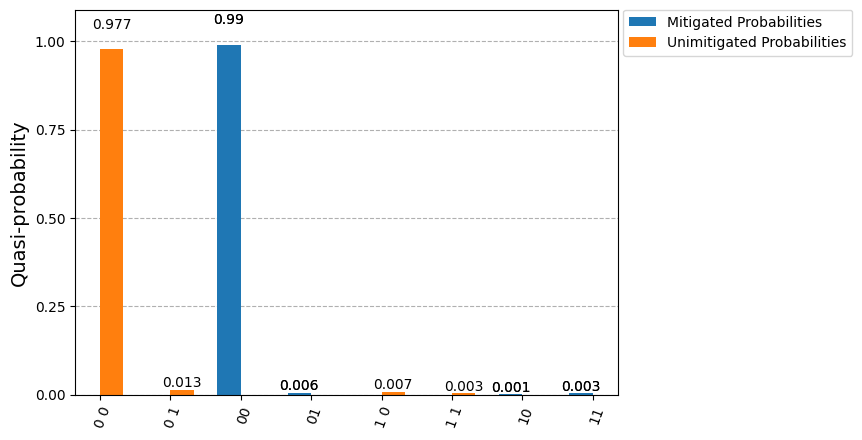

In [20]:
# Pick a mitigation_method (method_1 = least_squares, method_2 = throwaway zeros)
# Parameter: 0 for pre-mitigator, 1 for post-mitigator
unmitigated_probs, mitigated_probs, mitigated_counts = mitigation_method_1(mitigator1)

# Index of a circuit [0:0π 1=π/2, 2=π, 3=3π/2]
i = 0

# Print unmitigated & mitigated counts and plot 

print("Unmitigated Counts: ")
print(unmitigated_counts[i]) 
print("Mitigated Counts: ")
print(mitigated_counts[i])
print("")
print("Unmitigated Prob: ")
print(unmitigated_probs[i])
print("Mitigated Prob: ")
print(mitigated_probs[i])

legend = ['Mitigated Probabilities','Unimitigated Probabilities']
plot_distribution([mitigated_probs[i], unmitigated_probs[i]], legend=legend)

SCATTER PLOT OVER ALL ANGLES

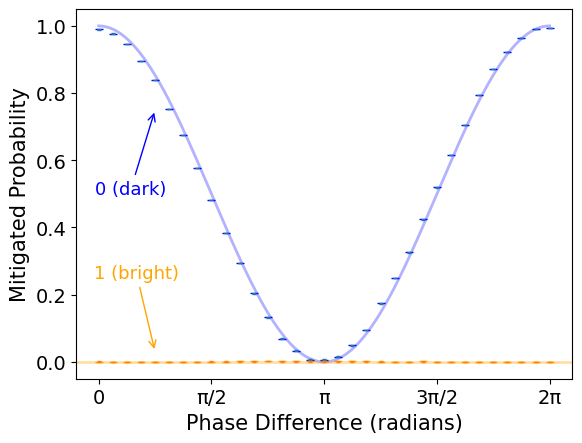

In [44]:
# Extract x, y data 
x = [(pi/16)*i for i in range(len(mitigated_probs))]
y_0 = [d.get('00', 0) for d in mitigated_probs]
y_1 = [d.get('10', 0) for d in mitigated_probs]

# Calculate standard error (SE = sqrt(p(1-p)/n)) measures how much the probability varies from the true probability.
y_err = [np.sqrt(y_0[i] * y_1[i]/(mitigated_counts[i].get('00',0) + mitigated_counts[i].get('10',0)))*1.96 for i in range (len(mitigated_probs))]

# Theoretical graphs
theta = np.linspace(0, 2*np.pi, 1000)
cos_squared = np.cos(theta/2)**2
plt.plot(theta, cos_squared, color='blue', alpha=0.3, linewidth = 2)
plt.axhline(y=0, color='orange', alpha=0.35, linestyle='-', linewidth=2)

# Create a scatter a scatter plot
plt.errorbar(x, y_0, yerr=y_err, capsize=1.7, linestyle = 'none')
plt.errorbar(x, y_1, yerr=y_err, capsize=1.7, linestyle = 'none')
plt.scatter(x,y_0, color='blue', label='0 (dark)', marker="_", linewidths=1)
plt.scatter(x,y_1, color='orange', label='1 (bright)', marker="_", linewidths=1)


plt.xlabel('Phase Difference (radians)', size = 15)
tick_positions = [(pi/2)*i for i in range(5)]
tick_labels = (['0', 'π/2' , 'π', '3π/2', '2π'])
plt.xticks(tick_positions, tick_labels, fontsize = 14)
plt.ylabel('Mitigated Probability', size = 15)
plt.yticks(fontsize = 14)
plt.annotate('0 (dark)', xy=(pi/4, 0.75), xytext=(pi/7, 0.5),
             arrowprops=dict(facecolor='blue', edgecolor="blue", arrowstyle='->'),
             fontsize=13, ha='center', color = "blue")
plt.annotate('1 (bright)', xy=(pi/4, 0.03), xytext=(pi/6, 0.25),
             arrowprops=dict(facecolor='orange', edgecolor="orange", arrowstyle='->'),
             fontsize=13, ha='center', color = "orange")
plt.savefig("7.Double_PBS_w_Erasers_result.png", dpi=300)